In [1]:
from collections import Counter
from wordcloud import WordCloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

/home/kevin/.pyenv/versions/3.7.3/envs/IM7001/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Import data

In [2]:
yelpZip_reviewContent = pd.read_csv('../../data/raw/YelpZip/reviewContent', sep='[\t]', names=['userId','prodId','date','content'], header=None, engine='python')
yelpZip_metadata = pd.read_csv('../../data/raw/YelpZip/metadata', sep='[\t]', names=['userId','prodId', 'rating', 'label','date'], header=None, engine='python')
yelpZip_preprocessed = pd.read_pickle('../../data/processed/yelpZip_preprocessed.pkl')

print(f'yelpZip reviewContent shape: {yelpZip_reviewContent.shape}')
print(f'columns: {yelpZip_reviewContent.columns}\n')
print(f'yelpZip metadata shape: {yelpZip_metadata.shape}')
print(f'columns: {yelpZip_metadata.columns}\n')

yelpZip reviewContent shape: (608598, 4)
columns: Index(['userId', 'prodId', 'date', 'content'], dtype='object')

yelpZip metadata shape: (608598, 5)
columns: Index(['userId', 'prodId', 'rating', 'label', 'date'], dtype='object')



In [3]:
yelpZip_fulldata = yelpZip_reviewContent.copy()
yelpZip_fulldata['content_len'] = yelpZip_reviewContent['content'].str.split().str.len()
yelpZip_fulldata['label'] = yelpZip_metadata['label']
yelpZip_fulldata['rating'] = yelpZip_metadata['rating']
print(f'columns: {yelpZip_fulldata.columns}\n')

columns: Index(['userId', 'prodId', 'date', 'content', 'content_len', 'label',
       'rating'],
      dtype='object')



In [4]:
yelpZip_fulldata.head()

,userId,prodId,date,content,content_len,label,rating
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",36,-1,1.0
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,248,-1,1.0
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,50,-1,3.0
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,233,-1,5.0
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...,152,-1,5.0


## Save as pickle

In [5]:
yelpZip_fulldata.to_pickle('../../data/processed/yelpZip_fulldata.pkl')

# Exploration

## 0. Basic statistic

In [6]:
print(f'{len(yelpZip_fulldata)} reviews')
print(f'- {len(yelpZip_fulldata[yelpZip_fulldata["label"]==1])} true')
print(f'- {len(yelpZip_fulldata[yelpZip_fulldata["label"]==-1])} fake\n')
print(f'{len(yelpZip_fulldata["userId"].unique())} unique users')
print(f'{len(yelpZip_fulldata["prodId"].unique())} unique restaurants')

608598 reviews
- 528132 true
- 80466 fake

260277 unique users
5044 unique restaurants


## 1. Fake reviews v.s. True reviews

In [7]:
false_reviews = yelpZip_fulldata[yelpZip_fulldata["label"]==-1]
true_reviews = yelpZip_fulldata[yelpZip_fulldata["label"]==1]

### Count

<AxesSubplot:title={'center':'label count'}, ylabel='label'>

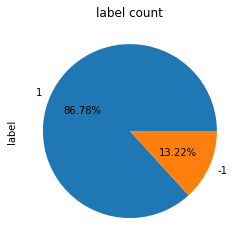

In [8]:
yelpZip_fulldata['label'].value_counts().plot.pie(autopct="%.2f%%", title="label count")

### Content length

#### 1. Without tokenize

count    80466.000000
mean        87.095991
std         90.641654
min          1.000000
25%         30.000000
50%         60.000000
75%        112.000000
max        983.000000
Name: content_len, dtype: float64


<AxesSubplot:title={'center':'Fake reviews content length'}, ylabel='Frequency'>

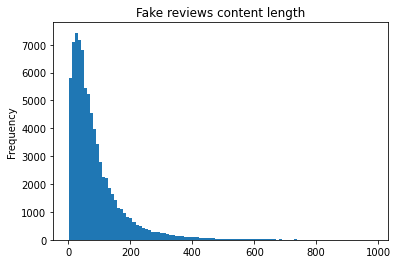

In [9]:
print(false_reviews["content_len"].describe())
false_reviews['content_len'].plot.hist(bins=100, title='Fake reviews content length')

count    528132.000000
mean        119.589269
std         107.374770
min           1.000000
25%          47.000000
50%          89.000000
75%         158.000000
max        1004.000000
Name: content_len, dtype: float64


<AxesSubplot:title={'center':'True reviews content length'}, ylabel='Frequency'>

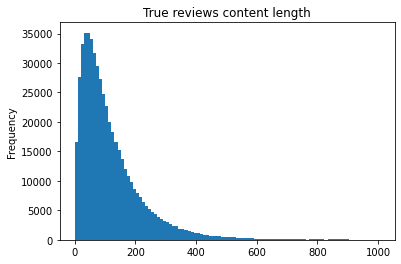

In [10]:
print(true_reviews["content_len"].describe())
#true_reviews['content_len'].hist(bins=100)
true_reviews['content_len'].plot.hist(bins=100, title='True reviews content length')

#### 2. With tokenize

count    80466.000000
mean        44.929088
std         45.371750
min          0.000000
25%         17.000000
50%         32.000000
75%         57.000000
max        716.000000
Name: tokenize_content_len, dtype: float64


<AxesSubplot:title={'center':'Fake reviews content length with tokenization'}, ylabel='Frequency'>

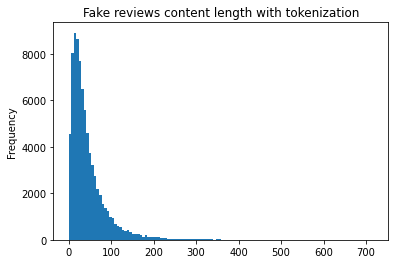

In [11]:
print(yelpZip_preprocessed[yelpZip_preprocessed['label']==-1]['tokenize_content_len'].describe())
yelpZip_preprocessed[yelpZip_preprocessed['label']==-1]['tokenize_content_len'].plot.hist(bins=120, title='Fake reviews content length with tokenization')

count    528132.000000
mean         62.673322
std          55.469286
min           0.000000
25%          25.000000
50%          47.000000
75%          82.000000
max         527.000000
Name: tokenize_content_len, dtype: float64


<AxesSubplot:title={'center':'True reviews content length with tokenization'}, ylabel='Frequency'>

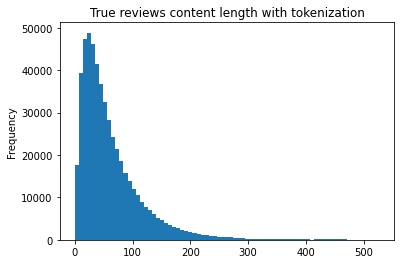

In [12]:
print(yelpZip_preprocessed[yelpZip_preprocessed['label']==1]['tokenize_content_len'].describe())
yelpZip_preprocessed[yelpZip_preprocessed['label']==1]['tokenize_content_len'].plot.hist(bins=75, title='True reviews content length with tokenization')

### Ratings

#### 1. All

<AxesSubplot:title={'center':'All reviews rating distribution'}, ylabel='Frequency'>

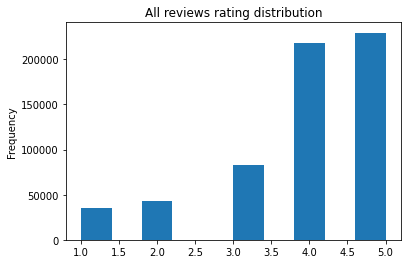

In [13]:
yelpZip_fulldata['rating'].plot.hist(title='All reviews rating distribution')

#### 2. Fake reviews

<AxesSubplot:title={'center':'Fake reviews rating distribution'}, ylabel='Frequency'>

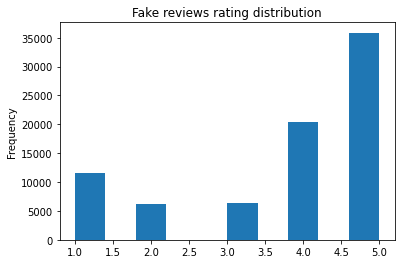

In [14]:
false_reviews['rating'].plot.hist(title='Fake reviews rating distribution')

#### 3. True reviews

<AxesSubplot:title={'center':'True reviews rating distribution'}, ylabel='Frequency'>

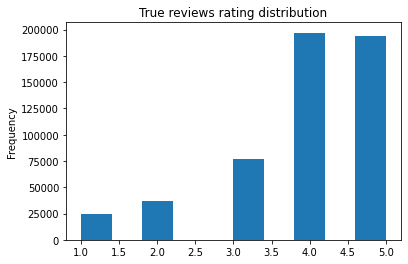

In [15]:
true_reviews['rating'].plot.hist(title='True reviews rating distribution')

## 2. Users

In [16]:
print(f'there are total {len(yelpZip_fulldata["userId"].unique())} unique users out of {yelpZip_fulldata.shape[0]} records\n')

there are total 260277 unique users out of 608598 records



### Review count per user

count    260277.000000
mean          2.338270
std           4.496138
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         197.000000
Name: prodId, dtype: float64


<AxesSubplot:title={'center':'Reviews count per user'}, ylabel='Frequency'>

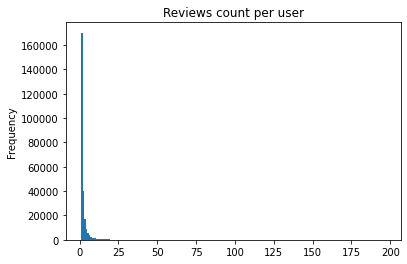

In [17]:
user_unique_review_count = yelpZip_fulldata.groupby('userId')['prodId'].nunique()

print(user_unique_review_count.describe())
user_unique_review_count.plot.hist(bins=200, title='Reviews count per user')

## 3. Restaurants

In [18]:
print(f'there are total {len(yelpZip_fulldata["prodId"].unique())} unique restaurants out of {yelpZip_fulldata.shape[0]} records\n')

there are total 5044 unique restaurants out of 608598 records



### Review count per restaurant

count    5044.000000
mean      120.657811
std       300.164451
min         1.000000
25%         8.000000
50%        33.000000
75%       108.000000
max      7378.000000
Name: userId, dtype: float64


<AxesSubplot:title={'center':'Reviews count per restaurant'}, ylabel='Frequency'>

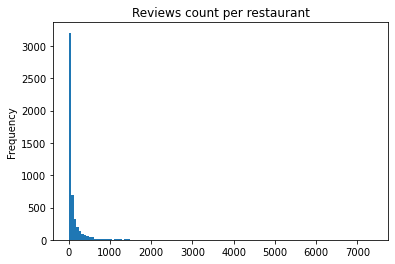

In [19]:
restaurant_unique_review_count = yelpZip_fulldata.groupby('prodId')['userId'].nunique()

print(restaurant_unique_review_count.describe())
restaurant_unique_review_count.plot.hist(bins=120, title='Reviews count per restaurant')

### Fake review per restaurant

In [20]:
print(f'there are {len(false_reviews["prodId"].unique())} restaurants out of {len(yelpZip_reviewContent["prodId"].unique())} that has fake reviews\n')

there are 4336 restaurants out of 5044 that has fake reviews



count    4336.000000
mean       18.557657
std        38.630452
min         1.000000
25%         3.000000
50%         9.000000
75%        21.000000
max       797.000000
Name: userId, dtype: float64


<AxesSubplot:title={'center':'Fake reviews count per restaurant'}, ylabel='Frequency'>

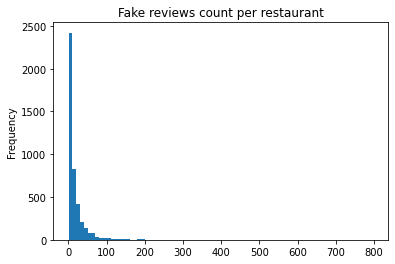

In [21]:
restaurant_unique_false_review_count = false_reviews.groupby('prodId')['userId'].nunique()

print(restaurant_unique_false_review_count.describe())

restaurant_unique_false_review_count.plot.hist(bins=80, title='Fake reviews count per restaurant')

## 4. Word Cloud

### Without removing top N common words

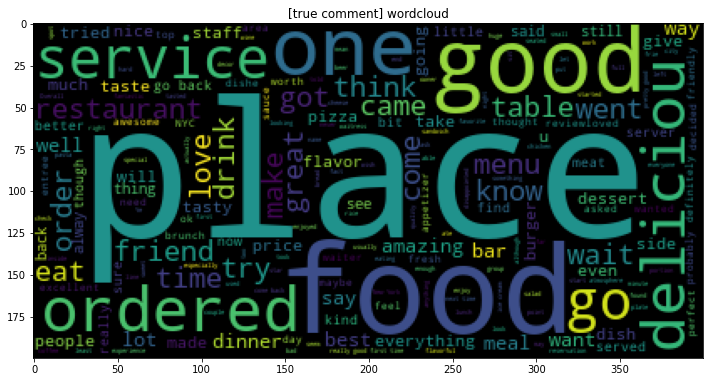

In [22]:
true_cloud = WordCloud().generate(' '.join(true_reviews["content"]))

plt.figure(figsize=(12,10))
plt.title('[true comment] wordcloud')
plt.imshow(true_cloud)

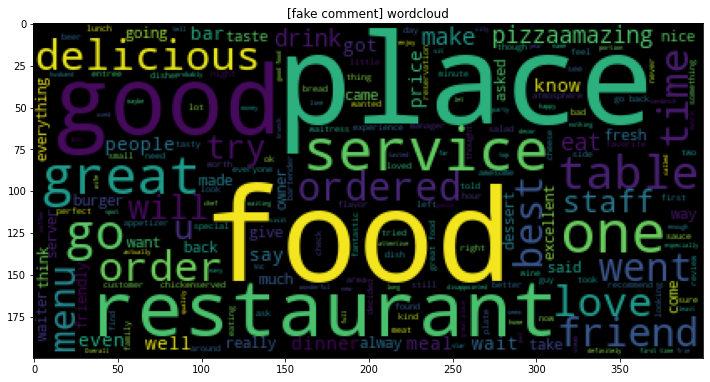

In [23]:
false_cloud = WordCloud().generate(' '.join(false_reviews["content"]))

plt.figure(figsize=(12,10))
plt.title('[fake comment] wordcloud')
plt.imshow(false_cloud)

### With removing top N common words

In [25]:
top_n = 6

true_word_list = list(yelpZip_preprocessed[yelpZip_preprocessed['label']==1]['tokenize_content'])
true_word_list = list(itertools.chain.from_iterable(true_word_list))
true_word_common = Counter(true_word_list).most_common(top_n)

fake_word_list = list(yelpZip_preprocessed[yelpZip_preprocessed['label']==-1]['tokenize_content'])
fake_word_list = list(itertools.chain.from_iterable(fake_word_list))
fake_word_common = Counter(fake_word_list).most_common(top_n)

df_true = pd.DataFrame(true_word_common)
df_false = pd.DataFrame(fake_word_common)
common_words = list(set(df_true.iloc[:,0]) & set(df_false.iloc[:,0]))
print(common_words)
print(f'there are {len(common_words)} common word in top {top_n} words')

['great', 'place', 'good', 'food', 'time']
there are 5 common word in top 6 words


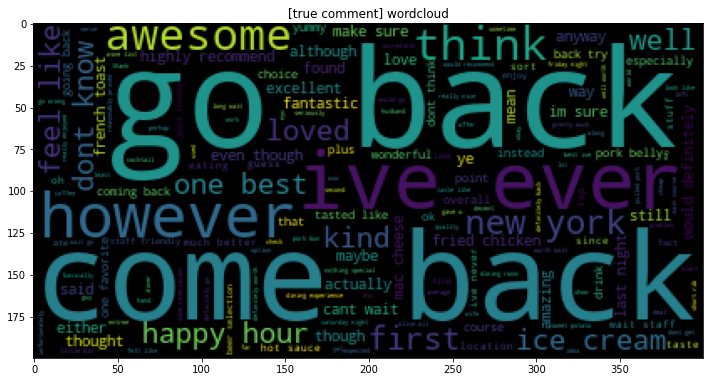

In [26]:
true_cloud_update = WordCloud(stopwords=common_words).generate(' '.join(yelpZip_preprocessed[yelpZip_preprocessed['label']==1]['corpus']))

plt.figure(figsize=(12,10))
plt.title('[true comment] wordcloud')
plt.imshow(true_cloud_update)

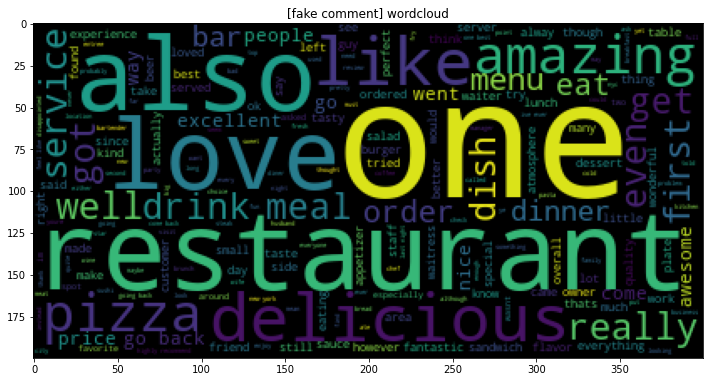

In [27]:
false_cloud_update = WordCloud(stopwords=common_words).generate(' '.join(yelpZip_preprocessed[yelpZip_preprocessed['label']==-1]['corpus']))

plt.figure(figsize=(12,10))
plt.title('[fake comment] wordcloud')
plt.imshow(false_cloud_update)